**Here we difine some parameters for model training
such as: the training proportion (train_prop)
the image size (patch size)
iteration number (epoch)
learning rate (lr)
and some information about data (spectral bands, number of catagory)**

In [ ]:
#some python packages that used for loading and pre-processing data
import scipy.io as sio
import numpy as np

data_dir = "Indian_pines_corrected.mat" # where is hyperspectral image (hsi) data
label_dir = "Indian_pines_gt.mat" # where is the label/ground truth data
train_prop = 0.1  # the total training proportion
val_prop = 0.1  # the total validating proportion, which is used for selecting the best model during the training process. We split the data into three parts, i.e., train, validation, test
patch_size = 9  # cuz we are using patch-based classificaition, this parameter is used for crop the hsi into patch image with size of 9.
epoch = 300 # number of iteration
batch_size = 128  # number of one-time data that fed into the model
lr = 0.0001 # learning rate, which control the direction and strength of gradient descent. e.g., c_{t} = c_{t-1} - lr * gradient
img_channel = 200 # the number of spectrla band of hsi
num_classes = 16  # the number of category of hsi
input_shape = [batch_size, img_channel, patch_size, patch_size] # the input size of data fed into model, we have total number of batch_size for cropped hsi with size of [img_channel, patch_size, patch_size]

**Here is the function to load and normalize the data**

In [ ]:
def read_data(data_dir, target_dir):
    """

    Parameters
    ----------
    data_dir: str, e.g. '/Indian_pines_corrected.mat'
    target_dir: str, e.g. '/Indian_pines_gt.mat'

    Returns
    -------
    data: ndarray, C*H*W   200*145*145
    target: ndarray, H*W   145*145

    """

    data = sio.loadmat(data_dir) # load data using sio.loadmat
    data = list(filter(lambda x: isinstance(x, np.ndarray), data.values()))[0]   # filter the data
    data = data.transpose(2, 0, 1)   # (145*145*200) --->  (200*145*145)  make some transposition
    data = normalize(data)  # normalize the data to the range of (0, 1)

    label = sio.loadmat(target_dir)   # load the label data
    label = list(filter(lambda x: isinstance(x, np.ndarray),
                         label.values()))[0]

    return data, label


def normalize(data):
    data = data.astype(np.float32)
    norm_data = np.zeros(data.shape)
    for i in range(len(data)):
        input_max = np.max(data[i, :, :])
        input_min = np.min(data[i, :, :])
        norm_data[i, :, :] = (data[i, :, :] - input_min) / (input_max - input_min)  # [0, 1]

    return norm_data


**Here we load the using the function 'read_data', and display the data**

The shape of data: (200, 145, 145)


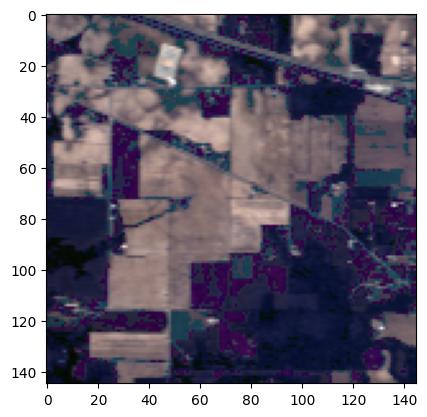

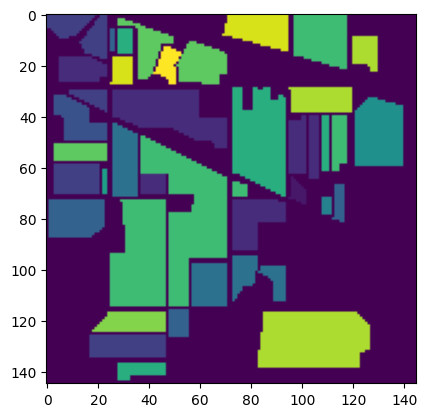

In [ ]:
hyperspectral_cube, label = read_data(data_dir, label_dir)  # return the observation data and label using read_data function
print("The shape of data:", hyperspectral_cube.shape)

import matplotlib.pyplot as plt

plt.imshow(hyperspectral_cube[[30,20,15], :, :].transpose(1,2,0)) # randomly select three bands to display the image, and also the laebl
plt.show()

plt.imshow(label)
plt.show()

**Here we get the training sample**

In [ ]:
def get_proportional_masks(target, train_prop, val_prop):
    """get masks that be used to extracted training/val/test samples, training
    samples number is determined by the proportion

    Parameters
    ----------
    target: ndarray, H*W, the ground truth of HSI
    train_prop: float, the proportion of training samples, e.g. 0.2
    val_prop: float, the proportion of validation samples, e.g. 0.2
    save_dir: str, masks save path, a folder not a file path,
    e.g. './indian_pines'

    Returns
    -------
    train_mask: ndarray, H*W
    val_mask: ndarray, H*W
    test_mask: ndarray, H*W

    """

    assert train_prop + val_prop < 1   # make sure the sum of train and validation proportion is lees than 1
    train_mask = np.zeros((target.shape[0], target.shape[1]))   # 145*145   initialize a matrix that will record the location of training sample
    val_mask = train_mask.copy() # also initialize a matrix that will record the location of validating sample
    test_mask = train_mask.copy()   # initialize a matrix that will record the location of testing sample

    for i in range(1, target.max() + 1):
        idx = np.argwhere(target == i)    # find the location of specific category using np.argwhere, and return the index/location
        # at least 3 samples for training
        train_num = max(int(round(len(idx) * train_prop)), 3)   # get the number of training sample according the proportion.
        val_num = max(int(round(len(idx) * val_prop)), 3)     # get the number of validating sample according the proportion.

        np.random.shuffle(idx)    # do some shuffling for slecting sample randomly
        train_idx = idx[:train_num]   # get the first train_num samples wiil be choosed
        val_idx = idx[train_num:train_num + val_num] # From train_num to train_num+val_num will be selected
        test_idx = idx[train_num + val_num:]  # also for testing data

        # the index=1 is the sample we need
        train_mask[train_idx[:, 0], train_idx[:, 1]] = 1  # give the number 1 for the sample we select
        val_mask[val_idx[:, 0], val_idx[:, 1]] = 1    # give the number 1 for the sample we select
        test_mask[test_idx[:, 0], test_idx[:, 1]] = 1   # give the number 1 for the sample we select

    return train_mask, val_mask, test_mask

**Here we display the data distribution of training sample**

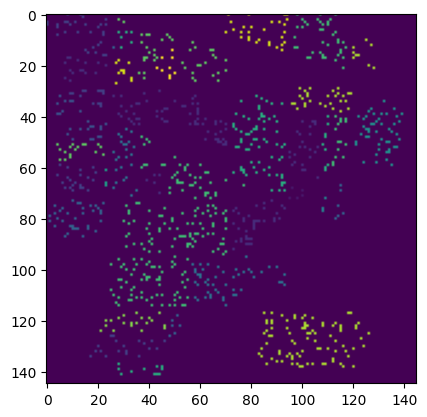

In [ ]:
train_mask, val_mask, test_mask = get_proportional_masks(label, train_prop, val_prop)  # return the mask we generate

plt.imshow(train_mask * label)  # display the distribution of training sample
plt.show()

**Here we get the patch data by cropping the raw data, the catetgory of patch data is defined by the label of central pixle**

In [ ]:
def get_sample(data, target, mask, patch_size=13):
    # padding
    width = patch_size//2   # cuz we are do the patch-baed classification, generally, we assign label for the central pixel
    data = np.pad(data, ((0, 0), (width, width), (width, width)), 'reflect')    # do same padding (zero padding) for selecting the pixle on the edge.
    target = np.pad(target, ((width, width), (width, width)), 'constant')     # also
    mask = np.pad(mask, ((width, width), (width, width)), 'constant')   # also

    target = target * mask    # get the label of each sample
    target = target[target != 0]-1    # in python, the first index is from 0, unlike Matlab, the index is from 1. Gewnerally, we set the label form 0 to total number of class

    patch_data = np.zeros((target.size, data.shape[0], patch_size, patch_size), dtype='float32')    # size of data, [total_number, patch_size, patch_size]
    indx = np.argwhere(mask == 1) # get the location of samples

    for i, col in enumerate(indx):
        patch = data[:, col[0]-width:col[0]+width+1, col[1]-width:col[1]+width+1]  # do some copping, making sure that the central pixel has there corresponding label
        patch_data[i, :, :, :] = patch

    return patch_data, target

In [ ]:
train_data, train_target = get_sample(hyperspectral_cube, label, train_mask, patch_size)  # return the patch data

val_data, val_target = get_sample(hyperspectral_cube, label, val_mask, patch_size)    # also


print('the shape of training data:', train_data.shape)    # we have total 1026 training samples

the shape of training data: (1026, 200, 9, 9)


**Here we pack the training into dataset**

In [ ]:
# import some python packages form loading the pytorch dataset for iteratively feeding into the model
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

class common_dataset(Dataset):
    """
    Args:
        data: ndarray, [batch_size, 200, 9, 9]
        target: ndarray, [batch_size,]
    """

    def __init__(self, data, target, cuda=True):

        super(common_dataset, self).__init__()  #

        self.data = torch.from_numpy(data).float()    # convert hsi into tensor format, usually with the torch.float32 format
        self.target = torch.from_numpy(target).long()  # convert label into tensor format, usually with the torch.long format

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        return self.data[item], self.target[item]  # make sure that the data and labels are matched

In [ ]:
train_dataset = common_dataset(train_data, train_target)    # return the training dataset

val_dataset = common_dataset(val_data, val_target)    # also the validation dataset

**Here we define the simple CNN model**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, in_channel, num_classes):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channel, 128, kernel_size=3, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        # here is a common convolution block with convolution layer, batchnormalization(do normaliztion along the batch_size dimension) and activation funciton
        # in_channel is the spectral band of hsi, 128 means that we have 128 kernel, 3 means the kernel size, 1 means the moving step of kernel
        # as result, if the input data size is [128, 200, 9, 9], aftering operating this block. we will get the feature map with size [128, 128, 9, 9]
        # here, because of the setting of convolution layer, w there is no spatial downsampling to reduce the spatial size

        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )   # also

        self.pool = nn.AdaptiveAvgPool2d(output_size=1)  # average pooling, the sptial size will be 1
        self.fc1 = nn.Linear(256, 512)    # a linear layer
        self.fc2 = nn.Linear(512, num_classes) # another one, for get the prediction of label

    def forward(self, x):   # here is the forward model of this simple cnn
        x = self.conv1(x)  # [batch_size, 128, 9, 9]
        x = self.conv2(x)   # [batch_size, 256, 1, 1]
        x = self.pool(x)  # [batch_size, 256, 1, 1]
        x = x.view(x.size(0), -1)   # [batch_size, 256]
        x = F.relu(self.fc1(x))   # [batch_size, 512]
        x = self.fc2(x)  # [batch_size, 16]
        return x


**Here we initialize the model**

In [ ]:
import os
model = SimpleCNN(img_channel, num_classes)  # initialize the model
print(model)    # print the structure of model

# Example input (replace with your actual input)
input = torch.randn(batch_size, img_channel, patch_size, patch_size)
output = model(input)
print("The shape of output:", output.shape)

SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(200, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=256, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=16, bias=True)
)
The shape of output: torch.Size([16, 16])


**Here is the training code**

In [ ]:
from copy import deepcopy
def train(model, train_dataset, val_dataset, params):
    """
    Args:
        model: CNN model
        train_dataset: training dataset
        val_dataset: validation dataset
        params: dict, e.g.
            {'epoch': 1000,
             'batch_size': 50,
             'lr': 0.0001,
            }
    """

    epoch = params.get('epoch')  # get the parameter
    batch_size = params.get('batch_size')  # also
    lr = params.get('lr')  # also

    # load data
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                                  shuffle=True)   # pack our data using DataLoader
    criterion = nn.CrossEntropyLoss()   # the loass function we use
    optimizer = optim.Adam(model.parameters(), lr=lr)  # the method of gradient descent we use

    model.train()   # tell the pytorch that here we begin to train our model, must we do

    best_record = None    # record the log
    state_dict = None   # record the checkpoint of model
    best_model = None
    best_epoch, best_batch, best_train, best_val = 0, 0, 0., 0.
    best_loss = 10000000
    for e in range(epoch):  # total epoch

        for i, (data, target) in enumerate(train_dataloader):   # get the data pair   (hsi, label)

            optimizer.zero_grad()   # we need to do this
            output = model(data)  # the forward process of model  output size: [batch_size, 16]
            loss = criterion(output, target)  # calculate the loss
            loss.backward()  # backward the loss and also calculate the gradient automatically
            optimizer.step()  # we must do this for updating the parameter
            print("current epoch {}, loss {:.4f}".format(e+1., loss.item()))    # do some printing
            # make validation
            if i == len(train_dataloader)-1:
                train_acc = test(model, train_dataset)    # get the accuracy
                val_acc = test(model, val_dataset)    # also

                print('epoch: %-5s, batch: %-2s, loss: %8.6f, train acc: %.6f, '
                    'val acc: %.6f' % (e + 1, i + 1, loss.item(), train_acc,
                                        val_acc))

                if val_acc > best_val:

                    best_val = val_acc
                    best_train = train_acc
                    best_epoch = e + 1
                    best_batch = i + 1
                    best_loss = loss.item()
                    best_model = deepcopy(model)
                    state_dict = deepcopy(model.state_dict())
                    best_record = {'epoch': epoch+1, 'loss': loss.item(), 'model': model,
                                    'train_acc': train_acc, 'val_acc': val_acc}

    print('-' * 80)
    print('epoch: %-5s, batch: %-2s, loss: %8.6f, train acc: %.6f, '
          'val acc: %.6f' % (best_epoch, best_batch, best_loss, best_train,
                             best_val))

    # save the best model used for latter testing
    save_dir = './model_save'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    model_name = "best_model" + '.pt'
    model_dir = os.path.join(save_dir, model_name)
    torch.save(state_dict, model_dir)
    return best_model

# here is the function to calculate the numerical index.
def test(model, dataset):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=10, shuffle=False)
    output = None
    for idx, batch_data in enumerate(dataloader):
        with torch.no_grad():
            # batch_output = model(batch_data[0].cuda()).cpu().data
            batch_output = model(batch_data[0])
        if idx == 0:
            output = batch_output
        else:
            output = torch.cat((output, batch_output), dim=0)   # concatenate the result along the batch_size dimension

    pred = torch.max(output, dim=1)[1].cpu().numpy()   # generally, we select the max number of each bacth data as the final prediction label
    target = dataset.target.cpu().numpy()  # true label
    pred = pred[target != 0]  # move out the background pixel which doesn't have label
    target = target[target != 0]
    oa = float((pred == target).sum()) / float(len(target))  # get the overall accuracy
    return oa

In [ ]:
best_model = train(model, train_dataset, val_dataset, {'epoch': 10, 'batch_size':
        batch_size, 'lr': lr})  # training code

current epoch 1.0, loss 1.1489
current epoch 1.0, loss 1.0747
current epoch 1.0, loss 1.1246
current epoch 1.0, loss 1.1037
current epoch 1.0, loss 1.2024
current epoch 1.0, loss 1.0515
current epoch 1.0, loss 1.0197
current epoch 1.0, loss 1.0211
current epoch 1.0, loss 1.1964
epoch: 1    , batch: 9 , loss: 1.196417, train acc: 0.556317, val acc: 0.544564
current epoch 2.0, loss 1.4391
current epoch 2.0, loss 0.9343
current epoch 2.0, loss 1.1141
current epoch 2.0, loss 1.0893
current epoch 2.0, loss 1.2371
current epoch 2.0, loss 1.0920
current epoch 2.0, loss 1.0931
current epoch 2.0, loss 0.9556
current epoch 2.0, loss 0.9377
epoch: 2    , batch: 9 , loss: 0.937697, train acc: 0.637610, val acc: 0.606268
current epoch 3.0, loss 1.0899
current epoch 3.0, loss 0.9437
current epoch 3.0, loss 1.0889
current epoch 3.0, loss 1.0680
current epoch 3.0, loss 1.0073
current epoch 3.0, loss 0.8617
current epoch 3.0, loss 1.1057
current epoch 3.0, loss 0.9931
current epoch 3.0, loss 0.8475
epo

**Here we test the model on test data**

In [ ]:
print("Predicting..........")

# load the best model
save_dir = './model_save'
model_name = "best_model" + '.pt'
model_dir = os.path.join(save_dir, model_name)


model.load_state_dict(torch.load(model_dir))
model.eval()   # we must do this when we want to evaluate all the pixel after training the model

Predicting..........


<ipython-input-76-6e9ec65e3b44>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_dir))


SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(200, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=256, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=16, bias=True)
)

**Here we preapre the all patch data on raw data**

In [ ]:
def get_all_patches(data, patch_size):
    """get patches of all data points in the HSI data

    Parameters
    ----------
    data: ndarray, C*H*W
    patch_size: int, e.g. 13

    Returns
    -------
    patch_data: ndarray, N*C*P*P, N=H*W, P is patch size

    """
    width = patch_size // 2
    mask = np.ones((data.shape[1], data.shape[2]))  # 145*145

    patch_data = np.zeros((data.shape[1] * data.shape[2], data.shape[0],
                           patch_size, patch_size), dtype='float32')
    data = np.pad(data, ((0, 0), (width, width), (width, width)), 'reflect')
    mask = np.pad(mask, ((width, width), (width, width)), 'constant')
    index = np.argwhere(mask)
    for i, loc in enumerate(index):
        patch_data[i, :, :, :] = data[:, loc[0] - width:loc[0] + width+1,
                                 loc[1] - width:loc[1] + width+1]

    return patch_data



class PredictionData(Dataset):

    def __init__(self, all_data):

        super(PredictionData, self).__init__()

        self.data = torch.from_numpy(all_data).float()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):

        return self.data[item]

In [ ]:
pre_all = get_all_patches(hyperspectral_cube, patch_size=patch_size)    # get all the patch
predict_dataset = PredictionData(pre_all)

**Perdiction code**

In [ ]:
def predict(model, predict_dataset, batch_size):

    model.eval()  # we must do this

    dataloader = DataLoader(predict_dataset, batch_size=batch_size, shuffle=False)
    features = []
    for idx, (batch_data) in enumerate(dataloader):
        torch.cuda.empty_cache()
        with torch.no_grad():
            batch_output = model(batch_data)
            features.append(batch_output.detach().numpy())
        if idx == 0:
            output = batch_output
        else:
            output = torch.cat((output, batch_output), dim=0)


    output = torch.max(output, dim=1)[1].numpy() + 1    # because the index of ground truth is from 1, we need add 1 for our final prediction. the index of python is from 0

    return output, features

In [ ]:
pred, _ = predict(model, predict_dataset, batch_size=batch_size)  # make prediction for all the pixel

In [ ]:
pred = pred.reshape(hyperspectral_cube.shape[1], hyperspectral_cube.shape[2])   # reshape our results into [145,145]
y_pred_ = pred.copy()
y_pred_[label == 0] = 0

oa = float((y_pred_[y_pred_!=0] == label[label != 0]).sum()) / float(len(label[label != 0]))
print("overall accuracy: {:.4f} %".format(oa*100))

overall accuracy: 66.6602 %


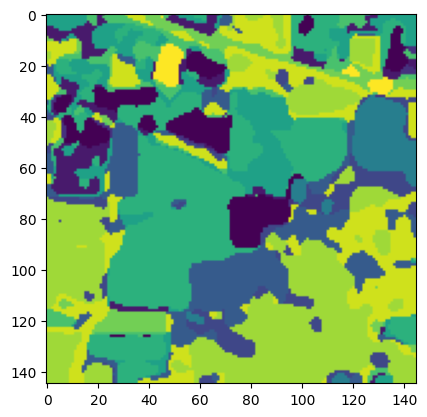

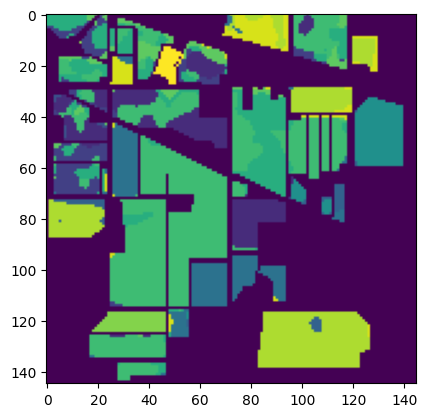

In [ ]:
plt.imshow(pred)
plt.show()

plt.imshow(y_pred_)
plt.show()